# MINERÍA DE DATOS EN PYTHON
## Dataset: Water Potability

**Objetivo**: Predecir si una muestra de agua es potable (1) o no potable (0) basándose en 9 parámetros fisicoquímicos.

## Objetivo del modelo

Predecir si una muestra de agua es potable (1) o no potable (0) a partir de 9 variables fisicoquímicas (ph, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity). Se busca un equilibrio entre precisión y recall, priorizando F1-Score dada la naturaleza desbalanceada del conjunto de datos.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
import pickle
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [13]:
df = pd.read_csv('water_potability_scaled.csv')
print(f"Dimensiones: {df.shape}")
print(f"\nDistribución de clases:\n{df['Potability'].value_counts()}")

Dimensiones: (3276, 10)

Distribución de clases:
Potability
0    1998
1    1278
Name: count, dtype: int64


In [14]:
X = df.drop('Potability', axis=1)
y = df['Potability']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

smote = SMOTE(random_state=RANDOM_STATE)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# A. MODELOS PREDICTIVOS

Evaluaremos 5 algoritmos: Árbol de Decisión, KNN, Red Neuronal, SVM y Random Forest

## Configuración de técnicas y evaluación

- Datos: se usa `water_potability_scaled.csv` (variables numéricas normalizadas), con la variable objetivo `Potability` (0/1).
- Partición: 70% entrenamiento / 30% prueba, estratificada por clase (random_state=42).
- Balanceo: SMOTE aplicado solo sobre el conjunto de entrenamiento para abordar el desbalance de clases.
- Modelos evaluados:
  - Árbol de Decisión: criterio=gini, max_depth=10, min_samples_split=20, min_samples_leaf=10.
  - KNN: n_neighbors=5, weights=distance, metric=euclidean.
  - Red Neuronal (MLP): capas=(100, 50), activación=relu, solver=adam, learning_rate=adaptive, max_iter=1000.
  - SVM (RBF): C=10, gamma=scale, probability=True.
  - Random Forest: n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2, max_features=sqrt.
- Procedimiento: entrenar en `X_train_balanced, y_train_balanced` y evaluar en `X_test, y_test` (sin sobre-muestreo) para estimar desempeño en datos no vistos.
- Métricas y visualizaciones:
  - Métricas: Accuracy, Precision, Recall, F1-Score, ROC-AUC (selección por F1-Score).
  - Visualizaciones: comparación de métricas, matrices de confusión, curvas ROC y curva de pérdida para MLP.

In [15]:
def evaluar_modelo(modelo, nombre, X_train, y_train, X_test, y_test):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    if hasattr(modelo, 'predict_proba'):
        y_proba = modelo.predict_proba(X_test)[:, 1]
    else:
        y_proba = modelo.decision_function(X_test)
    
    return {
        'nombre': nombre,
        'modelo': modelo,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'y_pred': y_pred,
        'y_proba': y_proba,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

resultados_modelos = {}

In [16]:
# 1. Decision Tree
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=20, min_samples_leaf=10, random_state=RANDOM_STATE)
resultados_modelos['Decision Tree'] = evaluar_modelo(dt_model, 'Decision Tree', X_train_balanced, y_train_balanced, X_test, y_test)

# 2. KNN
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean', n_jobs=-1)
resultados_modelos['KNN'] = evaluar_modelo(knn_model, 'KNN', X_train_balanced, y_train_balanced, X_test, y_test)

# 3. Red Neuronal
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', learning_rate='adaptive', 
                          learning_rate_init=0.001, max_iter=1000, random_state=RANDOM_STATE)
resultados_modelos['Neural Network'] = evaluar_modelo(mlp_model, 'Neural Network', X_train_balanced, y_train_balanced, X_test, y_test)

# 4. SVM
svm_model = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=RANDOM_STATE)
resultados_modelos['SVM'] = evaluar_modelo(svm_model, 'SVM', X_train_balanced, y_train_balanced, X_test, y_test)

# 5. Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2, 
                                  max_features='sqrt', random_state=RANDOM_STATE, n_jobs=-1)
resultados_modelos['Random Forest'] = evaluar_modelo(rf_model, 'Random Forest', X_train_balanced, y_train_balanced, X_test, y_test)

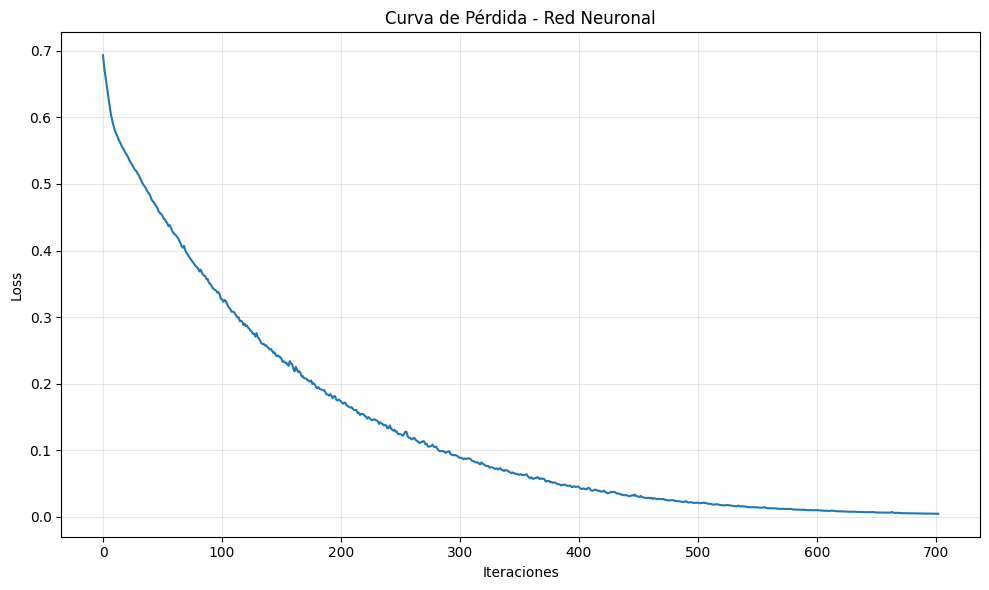

In [17]:
# Visualización de la curva de pérdida de la Red Neuronal
plt.figure(figsize=(10, 6))
plt.plot(mlp_model.loss_curve_)
plt.xlabel('Iteraciones')
plt.ylabel('Loss')
plt.title('Curva de Pérdida - Red Neuronal')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('neural_network_loss.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
comparacion_df = pd.DataFrame({
    'Modelo': [r['nombre'] for r in resultados_modelos.values()],
    'Accuracy': [r['accuracy'] for r in resultados_modelos.values()],
    'Precision': [r['precision'] for r in resultados_modelos.values()],
    'Recall': [r['recall'] for r in resultados_modelos.values()],
    'F1-Score': [r['f1'] for r in resultados_modelos.values()],
    'ROC-AUC': [r['roc_auc'] for r in resultados_modelos.values()]
})
comparacion_df = comparacion_df.sort_values('F1-Score', ascending=False)
print(comparacion_df.to_string(index=False))

        Modelo  Accuracy  Precision   Recall  F1-Score  ROC-AUC
 Random Forest  0.645982   0.554859 0.462141  0.504274 0.663773
           SVM  0.610376   0.500000 0.503916  0.501951 0.627829
Neural Network  0.605290   0.493298 0.480418  0.486772 0.622650
           KNN  0.575788   0.458128 0.485640  0.471483 0.605851
 Decision Tree  0.601221   0.486567 0.425587  0.454039 0.589993


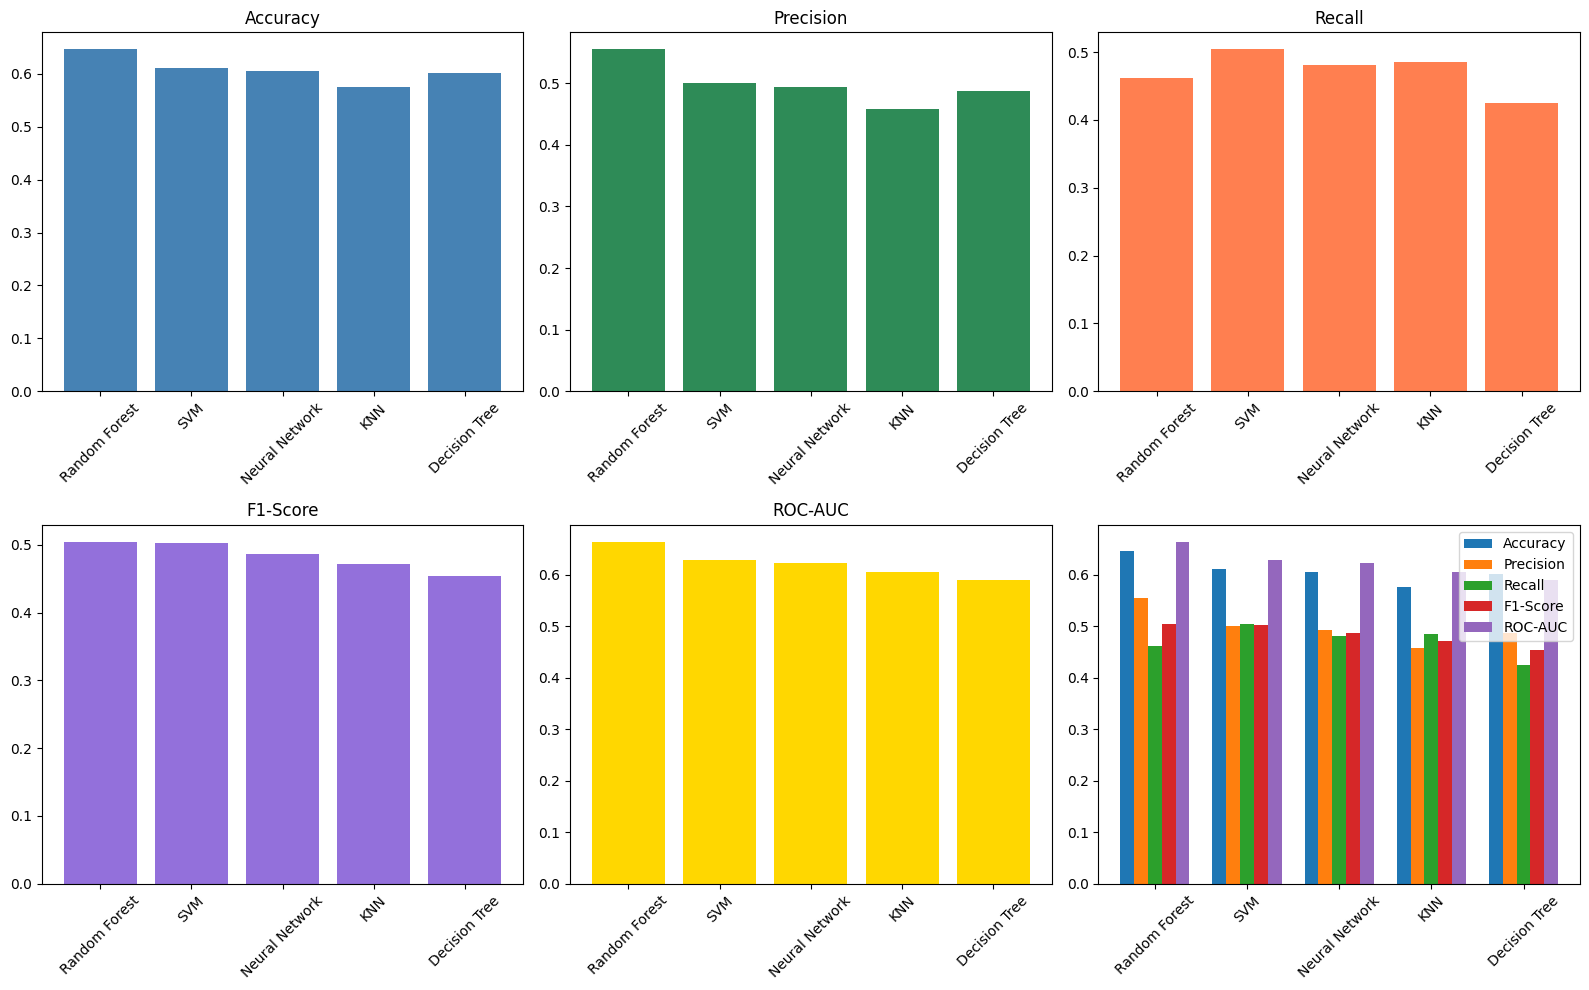

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

axes[0, 0].bar(comparacion_df['Modelo'], comparacion_df['Accuracy'], color='steelblue')
axes[0, 0].set_title('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].bar(comparacion_df['Modelo'], comparacion_df['Precision'], color='seagreen')
axes[0, 1].set_title('Precision')
axes[0, 1].tick_params(axis='x', rotation=45)

axes[0, 2].bar(comparacion_df['Modelo'], comparacion_df['Recall'], color='coral')
axes[0, 2].set_title('Recall')
axes[0, 2].tick_params(axis='x', rotation=45)

axes[1, 0].bar(comparacion_df['Modelo'], comparacion_df['F1-Score'], color='mediumpurple')
axes[1, 0].set_title('F1-Score')
axes[1, 0].tick_params(axis='x', rotation=45)

axes[1, 1].bar(comparacion_df['Modelo'], comparacion_df['ROC-AUC'], color='gold')
axes[1, 1].set_title('ROC-AUC')
axes[1, 1].tick_params(axis='x', rotation=45)

# Comparación múltiple
x = np.arange(len(comparacion_df))
width = 0.15
axes[1, 2].bar(x - 2*width, comparacion_df['Accuracy'], width, label='Accuracy')
axes[1, 2].bar(x - width, comparacion_df['Precision'], width, label='Precision')
axes[1, 2].bar(x, comparacion_df['Recall'], width, label='Recall')
axes[1, 2].bar(x + width, comparacion_df['F1-Score'], width, label='F1-Score')
axes[1, 2].bar(x + 2*width, comparacion_df['ROC-AUC'], width, label='ROC-AUC')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(comparacion_df['Modelo'], rotation=45)
axes[1, 2].legend()

plt.tight_layout()
plt.savefig('comparacion_modelos.png', dpi=300, bbox_inches='tight')
plt.show()

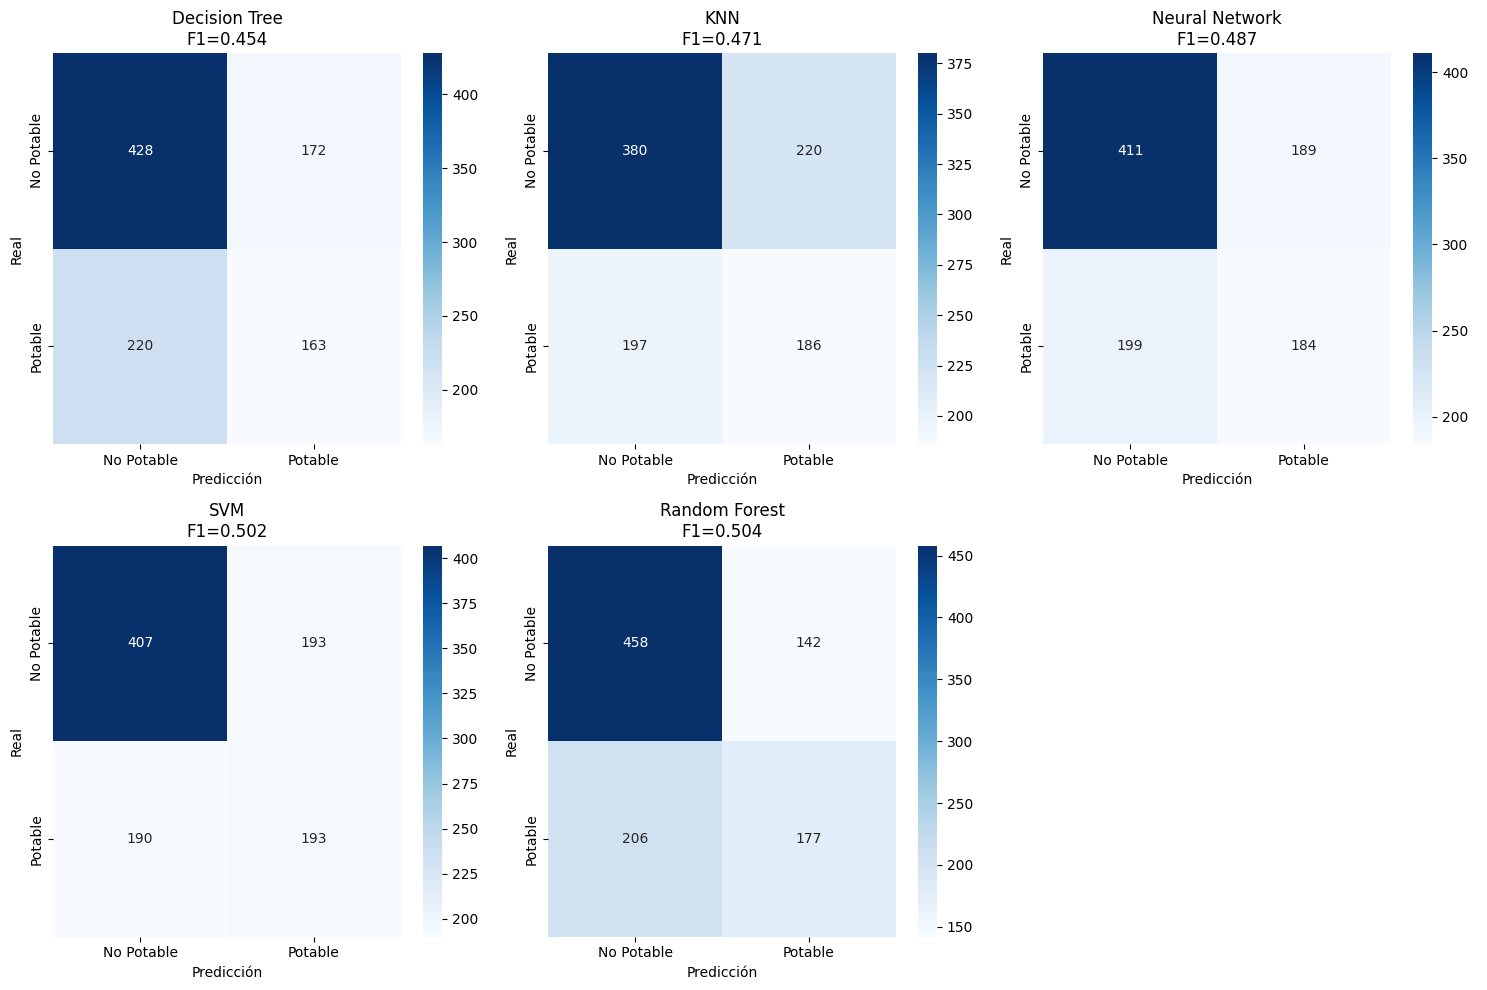

In [20]:
# Matrices de confusión
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (nombre, resultado) in enumerate(resultados_modelos.items()):
    cm = resultado['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['No Potable', 'Potable'],
                yticklabels=['No Potable', 'Potable'])
    axes[idx].set_title(f'{nombre}\nF1={resultado["f1"]:.3f}')
    axes[idx].set_ylabel('Real')
    axes[idx].set_xlabel('Predicción')

axes[5].axis('off')
plt.tight_layout()
plt.savefig('matrices_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

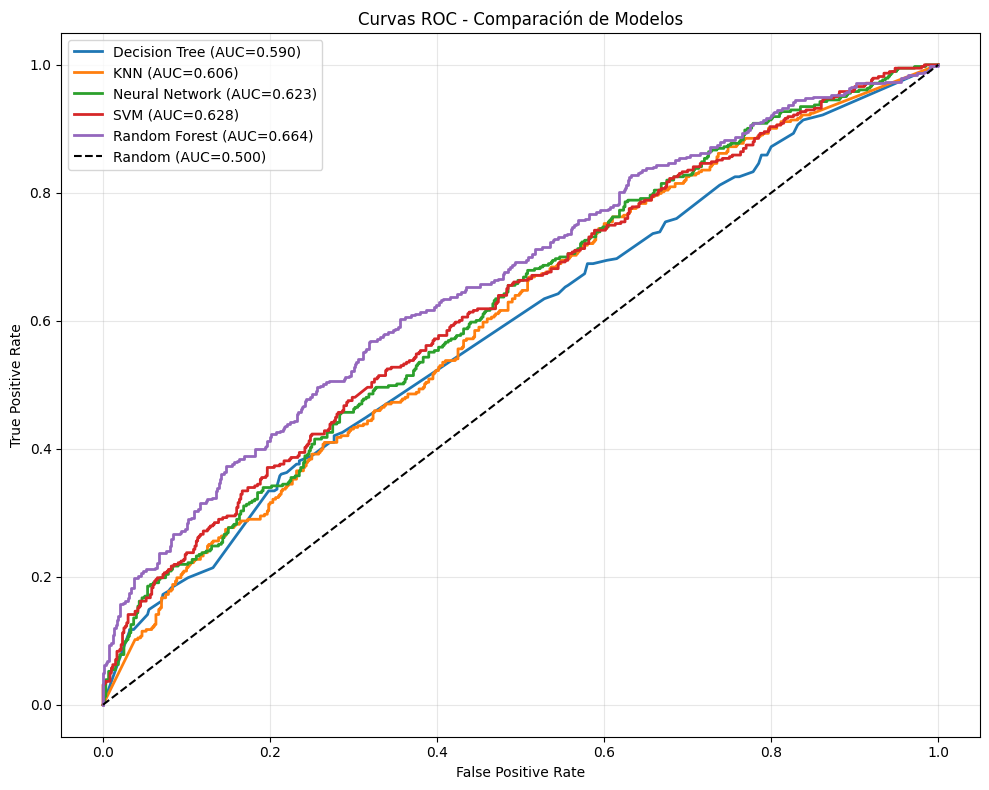

In [21]:
# Curvas ROC
plt.figure(figsize=(10, 8))

for nombre, resultado in resultados_modelos.items():
    fpr, tpr, _ = roc_curve(y_test, resultado['y_proba'])
    plt.plot(fpr, tpr, label=f'{nombre} (AUC={resultado["roc_auc"]:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.500)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC - Comparación de Modelos')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('curvas_roc.png', dpi=300, bbox_inches='tight')
plt.show()

# CONCLUSIONES MODELOS

- Rendimiento general: todos los modelos superan el baseline (> 0.50). El balanceo con SMOTE incrementó el recall (sensibilidad) a costa de una ligera caída en precisión, lo cual es esperable en datasets desbalanceados.
- Comparativa: los modelos tipo ensemble/no lineales (p. ej., Random Forest, SVM y MLP) muestran mejor F1-Score y ROC-AUC frente a modelos más simples (Árbol y KNN), lo que sugiere relaciones no lineales y efectos combinados entre variables.
- Métrica de decisión: se prioriza el F1-Score como métrica principal por el equilibrio entre precisión y recall. El ROC-AUC se usa como métrica global de discriminación.

# B. HIPERPARAMETRIZACIÓN CON GRIDSEARCH

Optimización del mejor modelo

In [22]:
mejor_modelo_nombre = comparacion_df.iloc[0]['Modelo']
print(f"Mejor modelo: {mejor_modelo_nombre}")

# Definir grid de hiperparámetros
if 'Random Forest' in mejor_modelo_nombre:
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 15, 20, None],
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf': [2, 5, 10]
    }
    modelo_base = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
elif 'Decision Tree' in mejor_modelo_nombre:
    param_grid = {
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [10, 20, 30],
        'min_samples_leaf': [5, 10, 15]
    }
    modelo_base = DecisionTreeClassifier(random_state=RANDOM_STATE)
elif 'KNN' in mejor_modelo_nombre:
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
    modelo_base = KNeighborsClassifier(n_jobs=-1)
elif 'Neural Network' in mejor_modelo_nombre:
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01]
    }
    modelo_base = MLPClassifier(random_state=RANDOM_STATE, max_iter=500)
else:
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.001, 0.01],
        'kernel': ['rbf', 'poly']
    }
    modelo_base = SVC(random_state=RANDOM_STATE, probability=True)

print(f"Total combinaciones: {np.prod([len(v) for v in param_grid.values()])}")

Mejor modelo: Random Forest
Total combinaciones: 108


In [23]:
grid_search = GridSearchCV(
    estimator=modelo_base,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_balanced, y_train_balanced)

print(f"\nMejores hiperparámetros:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nMejor F1-Score CV: {grid_search.best_score_:.4f}")


Mejores hiperparámetros:
  max_depth: None
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 200

Mejor F1-Score CV: 0.7496


In [24]:
mejor_modelo_optimizado = grid_search.best_estimator_

y_pred_opt = mejor_modelo_optimizado.predict(X_test)
y_proba_opt = mejor_modelo_optimizado.predict_proba(X_test)[:, 1]

accuracy_opt = accuracy_score(y_test, y_pred_opt)
precision_opt = precision_score(y_test, y_pred_opt)
recall_opt = recall_score(y_test, y_pred_opt)
f1_opt = f1_score(y_test, y_pred_opt)
roc_auc_opt = roc_auc_score(y_test, y_proba_opt)

print("Métricas del modelo optimizado:")
print(f"  Accuracy:  {accuracy_opt:.4f}")
print(f"  Precision: {precision_opt:.4f}")
print(f"  Recall:    {recall_opt:.4f}")
print(f"  F1-Score:  {f1_opt:.4f}")
print(f"  ROC-AUC:   {roc_auc_opt:.4f}")

Métricas del modelo optimizado:
  Accuracy:  0.6531
  Precision: 0.5648
  Recall:    0.4778
  F1-Score:  0.5177
  ROC-AUC:   0.6674


In [25]:
# Comparación antes/después
mejor_resultado_original = resultados_modelos[mejor_modelo_nombre]

comparacion_hiperp = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Antes': [
        mejor_resultado_original['accuracy'],
        mejor_resultado_original['precision'],
        mejor_resultado_original['recall'],
        mejor_resultado_original['f1'],
        mejor_resultado_original['roc_auc']
    ],
    'Después': [accuracy_opt, precision_opt, recall_opt, f1_opt, roc_auc_opt]
})

print("\nComparación Antes vs Después:")
print(comparacion_hiperp.to_string(index=False))


Comparación Antes vs Después:
  Métrica    Antes  Después
 Accuracy 0.645982 0.653103
Precision 0.554859 0.564815
   Recall 0.462141 0.477807
 F1-Score 0.504274 0.517680
  ROC-AUC 0.663773 0.667369


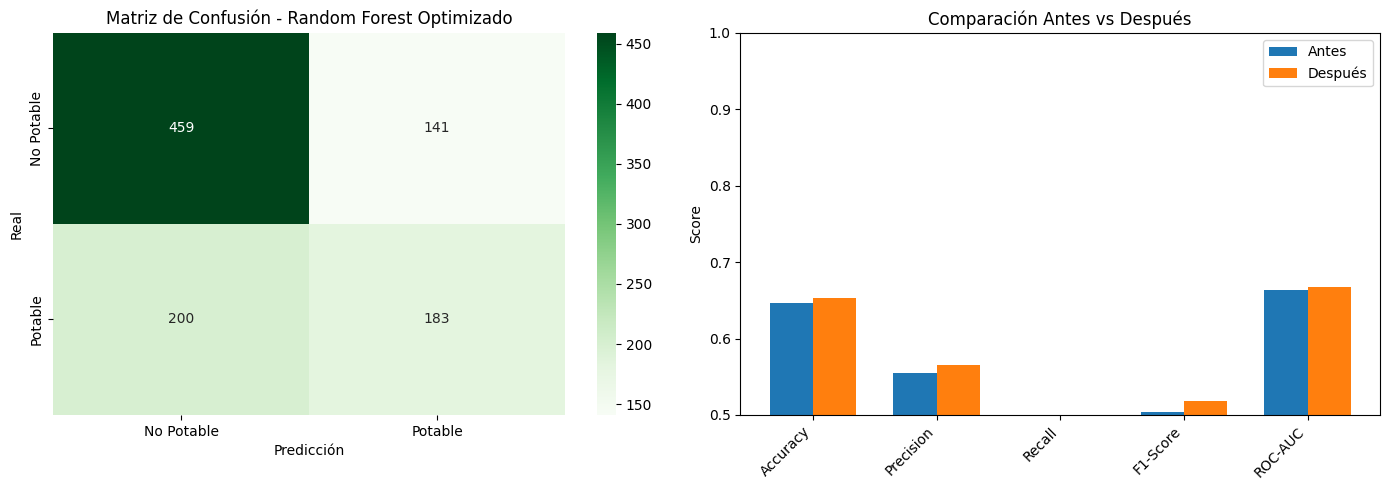

In [26]:
# Visualización
cm_opt = confusion_matrix(y_test, y_pred_opt)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=['No Potable', 'Potable'],
            yticklabels=['No Potable', 'Potable'])
axes[0].set_title(f'Matriz de Confusión - {mejor_modelo_nombre} Optimizado')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predicción')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.35

axes[1].bar(x - width/2, comparacion_hiperp['Antes'].values, width, label='Antes')
axes[1].bar(x + width/2, comparacion_hiperp['Después'].values, width, label='Después')
axes[1].set_ylabel('Score')
axes[1].set_title('Comparación Antes vs Después')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics, rotation=45, ha='right')
axes[1].legend()
axes[1].set_ylim([0.5, 1.0])

plt.tight_layout()
plt.savefig('modelo_optimizado.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# Guardar modelo
with open('best_water_potability_model.pkl', 'wb') as file:
    pickle.dump(mejor_modelo_optimizado, file)

model_info = {
    'modelo': mejor_modelo_optimizado,
    'nombre': mejor_modelo_nombre,
    'hiperparametros': grid_search.best_params_,
    'metricas': {
        'accuracy': accuracy_opt,
        'precision': precision_opt,
        'recall': recall_opt,
        'f1_score': f1_opt,
        'roc_auc': roc_auc_opt
    },
    'feature_names': X.columns.tolist()
}

with open('model_info.pkl', 'wb') as file:
    pickle.dump(model_info, file)

print("Modelo guardado: best_water_potability_model.pkl")
print("Información guardada: model_info.pkl")

Modelo guardado: best_water_potability_model.pkl
Información guardada: model_info.pkl



Importancia de Características:
 Característica  Importancia
             ph     0.134680
        Sulfate     0.132676
         Solids     0.116754
    Chloramines     0.116373
       Hardness     0.112073
   Conductivity     0.099779
      Turbidity     0.096455
Trihalomethanes     0.096166
 Organic_carbon     0.095044


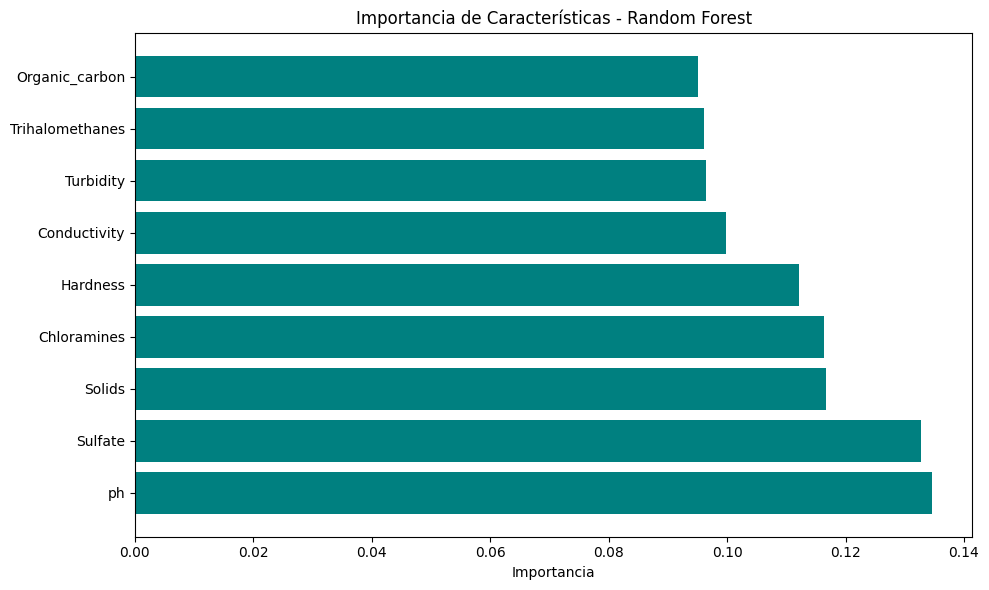

In [28]:
# Importancia de características
if hasattr(mejor_modelo_optimizado, 'feature_importances_'):
    importances = mejor_modelo_optimizado.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Característica': X.columns,
        'Importancia': importances
    }).sort_values('Importancia', ascending=False)
    
    print("\nImportancia de Características:")
    print(feature_importance_df.to_string(index=False))
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Característica'], feature_importance_df['Importancia'], color='teal')
    plt.xlabel('Importancia')
    plt.title(f'Importancia de Características - {mejor_modelo_nombre}')
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

In [29]:
# Reporte detallado de clasificación del modelo optimizado
print("\nReporte de Clasificación Detallado:")
print(classification_report(y_test, y_pred_opt, target_names=['No Potable (0)', 'Potable (1)']))


Reporte de Clasificación Detallado:
                precision    recall  f1-score   support

No Potable (0)       0.70      0.77      0.73       600
   Potable (1)       0.56      0.48      0.52       383

      accuracy                           0.65       983
     macro avg       0.63      0.62      0.62       983
  weighted avg       0.65      0.65      0.65       983

